In [3]:
cd /mnt/sda/otani/Experiments/moment_retrieval

/mnt/sda/otani/Experiments/moment_retrieval


In [4]:
import pandas as pd
import numpy as np
import spacy
import matplotlib.pyplot as plt
from src.toolbox.utils import _nms
from src.toolbox.eval import evaluate, accumulate_metrics
from src.toolbox.data_converters import CharadesSTA2Instances
import seaborn as sns
sns.set()
import json
import pickle as pkl
import neptune
sns.set_style("white")

In [5]:
# load ground truth testset
test_data = CharadesSTA2Instances(pd.read_csv('data/processed/test.csv'))

In [7]:
project = neptune.init("mayu-ot/moment-retrieval")

for exp_id in ["MOM-43", "MOM-51"]:
    if not os.path.exists(f"tmp/{exp_id}/TAN_vgg_rgb_test.pkl"):
        exps = project.get_experiments(id=exp_id)
        print("downloading results ...")
        exps[0].download_artifact("TAN_vgg_rgb_test.pkl", f"tmp/{exp_id}")
        print("done!")

downloading results ...
done!


In [11]:
predictions = pkl.load(open("tmp/MOM-43/TAN_vgg_rgb_test.pkl", "rb"))
preds = []
for p in predictions:
    query = (p[0][0], p[0][1]+".") # 2D-TAN remove '.' in description. Add to recover original input description.
    seg = p[1]
    keep = _nms(np.asarray(seg), np.arange(len(seg))[::-1], thresh=0.5, top_k=5)
    seg = [seg[i] for i in keep]
    preds.append((query, seg, np.arange(len(seg))[::-1].tolist()))
results = evaluate(test_data, preds)
summary = accumulate_metrics(results)

R@1 IoU>0.3 0.57
R@1 IoU>0.5 0.42
R@1 IoU>0.7 0.22
R@5 IoU>0.3 0.92
R@5 IoU>0.5 0.80
R@5 IoU>0.7 0.51
R@10 IoU>0.3 0.92
R@10 IoU>0.5 0.80
R@10 IoU>0.7 0.51


In [13]:
predictions = pkl.load(open("tmp/MOM-51/TAN_vgg_rgb_test.pkl", "rb"))
preds = []
for p in predictions:
    query = (p[0][0], p[0][1]+".") # 2D-TAN remove '.' in description. Add to recover original input description.
    seg = p[1]
    keep = _nms(np.asarray(seg), np.arange(len(seg))[::-1], thresh=0.5, top_k=5)
    seg = [seg[i] for i in keep]
    preds.append((query, seg, np.arange(len(seg))[::-1].tolist()))
randomized_results = evaluate(test_data, preds)
randomized_summary = accumulate_metrics(randomized_results)

R@1 IoU>0.3 0.54
R@1 IoU>0.5 0.39
R@1 IoU>0.7 0.20
R@5 IoU>0.3 0.91
R@5 IoU>0.5 0.77
R@5 IoU>0.7 0.48
R@10 IoU>0.3 0.91
R@10 IoU>0.5 0.77
R@10 IoU>0.7 0.48


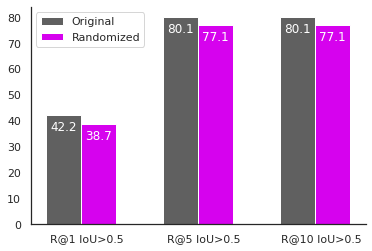

In [14]:
# The performances of the 2D-TAN model when the original and randomized videos are fed to the model
def display_score(bar, color="w"):
    plt.text(
        bar.get_x()+bar.get_width()*.5,
        bar.get_height()-6,
        f"{bar.get_height():.1f}",
        horizontalalignment="center",
        fontsize=12,
        color=color
    )
    
plt.figure(figsize=(6, 4))
c = ["#606060", "#d602ee"]
labels = ["Original", "Randomized"]
keys = [f"R@{k} IoU>0.5" for k in [1, 5, 10]]
x = np.arange(3)+0.2
for score_summary in [summary, randomized_summary]:
    vals = [score_summary[k] * 100 for k in keys]
    bars = plt.bar(x, vals, width=0.3, color=c.pop(0), label=labels.pop(0))
    for b in bars:
        display_score(b, color="w")
    x += 0.3
    
plt.xticks(ticks=np.arange(3)+0.4, labels=keys, ha="center")
    
plt.legend()
sns.despine(left=False)